In [1]:
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import sys
sys.path.append("..")
from RandomErasing import RandomErasing

import torchvision.models
from torchvision import transforms

from albumentations import Compose, ShiftScaleRotate, GridDistortion
from albumentations.pytorch import ToTensor

In [2]:
def prepare_data(df, unknown_to_known):
    df = df.reset_index()
    df['slno'] = df.assign(slno=1).groupby('audio_filename')['slno'].cumsum()
    df.set_index(['audio_filename', 'slno'], inplace=True)

    df_unknown = df.copy().loc[:, list(unknown_to_known.keys())]
    df.drop(columns=list(unknown_to_known.keys()), inplace=True)

    y_mask = df.copy()
    y_mask.loc[:, :] = 1
    for unknown, known in unknown_to_known.items():
        y_mask.loc[
            df_unknown[unknown] > 0.5,
            known
        ] = 0

    df = df.swaplevel(i=1, j=0, axis=0).sort_index()

    y_mask = y_mask.swaplevel(i=1, j=0, axis=0).sort_index()

    y = np.concatenate([
        df.loc[[1], :].values[..., np.newaxis],
        df.loc[[2], :].values[..., np.newaxis],
        df.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    y_mask = np.concatenate([
        y_mask.loc[[1], :].values[..., np.newaxis],
        y_mask.loc[[2], :].values[..., np.newaxis],
        y_mask.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    X = np.concatenate([
        np.expand_dims(np.load('../../data/logmelspec/{}.npy'.format(x)).T[:635, :], axis=0)
        for x in df.loc[[1], :].reset_index(1).audio_filename.tolist()])
    X = np.expand_dims(X, axis=1)

    return X, y, y_mask


random_erasing = RandomErasing()

In [3]:
class AudioDataset(Dataset):

    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = self.X[idx, ...]

        return sample, self.y[idx, ...], self.weights[idx, ...]

In [4]:
# Load and prepare data
with open('../../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

unknown_to_known = (
    pd.merge(metadata['taxonomy_df'].loc[lambda x: x.fine_id == 'X', ['fine', 'coarse']],
             metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X', ['fine', 'coarse']],
             on='coarse', how='inner')
    .drop(columns='coarse')
    .groupby('fine_x')['fine_y']
    .apply(lambda x: list(x)).to_dict())
known_labels = metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X'].fine.tolist()

train_df = pd.concat([metadata['coarse_train'], metadata['fine_train']], axis=1, sort=True)
valid_df = pd.concat([metadata['coarse_test'], metadata['fine_test']], axis=1, sort=True)

In [5]:
# manual correction for one data point
train_df.loc[(train_df.sum(axis=1) == 37).copy(), :] = 0
valid_df.loc[(valid_df.sum(axis=1) == 37).copy(), :] = 0

In [6]:
train_X, train_y, train_y_mask = prepare_data(train_df, unknown_to_known)
valid_X, valid_y, valid_y_mask = prepare_data(valid_df, unknown_to_known)

In [7]:
# Channel wise normalization
channel_means = train_X.reshape(-1, 128).mean(axis=0).reshape(1, 1, 1, -1)
channel_stds = train_X.reshape(-1, 128).std(axis=0).reshape(1, 1, 1, -1)
train_X = (train_X - channel_means) / channel_stds
valid_X = (valid_X - channel_means) / channel_stds

In [8]:
valid_y_mask.shape

(443, 31, 3)

In [9]:
np.sum(valid_y_mask)

40626

In [10]:
443*31*3

41199

In [11]:
valid_dataset = AudioDataset(torch.Tensor(valid_X),
                             torch.Tensor(valid_y),
                             torch.Tensor(valid_y_mask))

val_loader = DataLoader(valid_dataset, 64, shuffle=False)

In [12]:
# Define the device to be used
cuda = True
device = torch.device('cuda:0' if cuda else 'cpu')
print('Device: ', device)

Device:  cuda:0


In [13]:
class Task5Model(nn.Module):

    def __init__(self, num_classes):

        super().__init__()

        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())

        self.mv2 = torchvision.models.mobilenet_v2(pretrained=True)

        self.final = nn.Sequential(
            nn.Linear(1280, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, num_classes))
        
    def forward(self, x):
        x = self.bw2col(x)
        x = self.mv2.features(x)
        x = x.max(dim=-1)[0].max(dim=-1)[0]
        x = self.final(x)
        return x

In [14]:
# Instantiate the model
model = Task5Model(31).to(device)

In [15]:
criterion = nn.BCEWithLogitsLoss(reduction='none')

---

In [17]:
all_val_losses = []
for i in range(19):
    model.load_state_dict(torch.load('./run1/model_system1_until_{}'.format(i)))

    this_epoch_valid_loss = 0
    for inputs, labels, masks in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            this_epoch_valid_loss += loss.detach().cpu().numpy()
    this_epoch_valid_loss /= len(val_loader)

    all_val_losses.append(this_epoch_valid_loss)


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

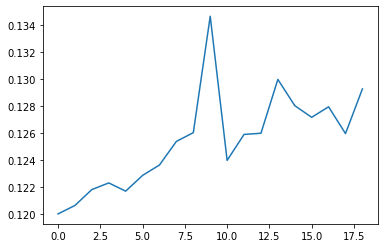

In [19]:
plt.plot(all_val_losses);

---

In [20]:
all_val_losses = []
for i in range(19):
    model.load_state_dict(torch.load('./run2/model_system1_until_{}'.format(i)))

    this_epoch_valid_loss = 0
    for inputs, labels, masks in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            this_epoch_valid_loss += loss.detach().cpu().numpy()
    this_epoch_valid_loss /= len(val_loader)

    all_val_losses.append(this_epoch_valid_loss)


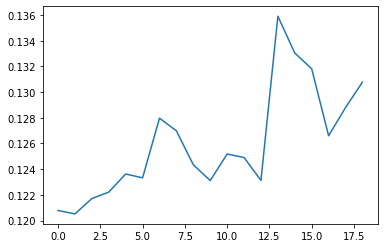

In [21]:
plt.plot(all_val_losses);

---

In [22]:
all_val_losses = []
for i in range(19):
    model.load_state_dict(torch.load('./run1-rev/model_system1_until_{}'.format(i)))

    this_epoch_valid_loss = 0
    for inputs, labels, masks in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            this_epoch_valid_loss += loss.detach().cpu().numpy()
    this_epoch_valid_loss /= len(val_loader)

    all_val_losses.append(this_epoch_valid_loss)


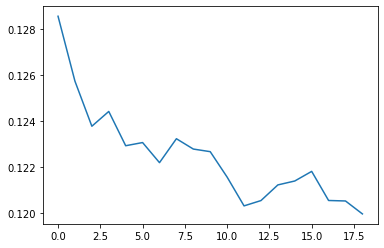

In [23]:
plt.plot(all_val_losses);

--